In [37]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import datetime as dt
from operator import attrgetter

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer


In [38]:
# read data 
df = pd.read_csv("D:\Python\Data\data.csv",
                 header=0,
                 encoding= "unicode_escape",
                 dtype={"CustomerID":str,
                        "InvoiceID":str},
                 parse_dates=["InvoiceDate"],
                 infer_datetime_format=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [39]:
# Summary

def summary(df):
    print(f"data shape: {df.shape}")
    summ = pd.DataFrame(df.dtypes, columns=["data type"])
    summ["#missing"] = df.isnull().sum().values
    summ["%missing"] = df.isnull().sum().values / len(df)* 100
    summ["#unique"] = df.nunique().values 
    desc = pd.DataFrame(df.describe(include="all").transpose())
    summ["min"] = desc["min"].values
    summ["max"] = desc["max"].values
    summ["first value"] = df.loc[0].values
    summ["scond values"] = df.loc[1].values
    summ["third values"] = df.loc[2].values
    return summ
summary(df)

data shape: (541909, 8)


,data type,#missing,%missing,#unique,min,max,first value,scond values,third values
InvoiceNo,object,0,0.000000,25900,NaN,NaN,536365,536365,536365
StockCode,object,0,0.000000,4070,NaN,NaN,85123A,71053,84406B
Description,object,1454,0.268311,4223,NaN,NaN,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER
Quantity,int64,0,0.000000,722,-80995.0,80995.0,6,6,8
InvoiceDate,datetime64[ns],0,0.000000,23260,2010-12-01 08:26:00,2011-12-09 12:50:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00
UnitPrice,float64,0,0.000000,1630,-11062.06,38970.0,2.55,3.39,2.75
CustomerID,object,135080,24.926694,4372,NaN,NaN,17850,17850,17850
Country,object,0,0.000000,38,NaN,NaN,United Kingdom,United Kingdom,United Kingdom


In [40]:
def replace_with_thresholds(dataframe , variable, q1 = 0.25, q3 = 0.75):
    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3-quartile1

    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit

    return df_

def ecommerce_preprocess(datafarme):
    df_ = datafarme.copy()

    # Missing value
    df_ = df_.dropna()

    # Cancelled Orders And Quantity
    df_ = df_[~df_["InvoiceNo"].str.contains("C",na = False)]
    df_ = df_[df_["Quantity"] > 0 ]

    # Replacing Outliers
    df_ = replace_with_thresholds(df_, "Quantity", q1=0.01, q3=0.099)
    df_ = replace_with_thresholds(df_, "UnitPrice", q1=0.01, q3=0.99)
    
    # Total Price
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]
    df_ = df_[df_["TotalPrice"] > 0]

    return df_

In [41]:
df = ecommerce_preprocess(df)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,2010-12-01 08:26:00,2.55,17850,United Kingdom,2.55
1,536365,71053,WHITE METAL LANTERN,1,2010-12-01 08:26:00,3.39,17850,United Kingdom,3.39
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,1,2010-12-01 08:26:00,2.75,17850,United Kingdom,2.75
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,1,2010-12-01 08:26:00,3.39,17850,United Kingdom,3.39
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,1,2010-12-01 08:26:00,3.39,17850,United Kingdom,3.39
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,1,2011-12-09 12:50:00,0.85,12680,France,0.85
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,1,2011-12-09 12:50:00,2.10,12680,France,2.10
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,1,2011-12-09 12:50:00,4.15,12680,France,4.15
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,1,2011-12-09 12:50:00,4.15,12680,France,4.15


In [42]:
# "Countries With Highest Total Purchase Amount"

purchase = df.groupby(["Country"], as_index=False)["TotalPrice"].agg("sum")
most_purchase_countries = purchase.sort_values("TotalPrice", ascending=False).head(10)
fig = go.Figure(data=[go.Bar(x=most_purchase_countries["Country"].astype(str),
                             y=most_purchase_countries["TotalPrice"],
                             marker={"color": most_purchase_countries["TotalPrice"],
                                     "colorscale": "viridis"})])

fig.update_traces(texttemplate= "£%{y:.3s}",textposition= "outside")
fig.update_layout(title="Countries With Highest Total Purchase Amount",
                  title_x= 0.5,
                  xaxis_title= "Countries",
                  yaxis_title= "Amount Sum",
                  plot_bgcolor= "white")
fig.show()

In [43]:
# Countries With Lowest Total Purchase Countries;

min_purchase_countries = purchase.sort_values("TotalPrice").head(10)
fig = go.Figure(data=[
    go.Bar(x=min_purchase_countries['Country'].astype(str),
           y=min_purchase_countries['TotalPrice'],
           marker={'color': min_purchase_countries['TotalPrice'],
                   'colorscale': 'Viridis'})])
fig.update_traces(texttemplate="£%{y:.2s}", textposition="inside")
fig.update_layout(title="Countries With Lowest Total Purchase Countries",
                  xaxis_title="Countries",
                  yaxis_title="Amount Sum",
                  plot_bgcolor="white")
fig.show()

In [44]:
# 15 Popular Products

products = df.pivot_table(index="Description", values="Quantity", aggfunc=np.sum).reset_index()
best_selling = products.sort_values("Quantity", ascending=False).head(15)
fig = go.Figure(data=[go.Bar(x=best_selling["Description"].astype(str),y=best_selling["Quantity"],marker={"color": best_selling["Quantity"],"colorscale": "viridis"})])

fig.update_traces(texttemplate="%{y:.2s}", textposition="inside")
fig.update_layout(title="'15 Popular Products'", 
                  title_x=0.5,
                  xaxis_title="Products",
                  yaxis_title="Total Quantity",
                  plot_bgcolor="white")
fig.update_xaxes(tickangle=15)
fig.show()

In [45]:
# 'Best Customers based on Purchase Amount
customers_country_based = df.groupby(["CustomerID", "Country"],as_index=False)["TotalPrice"].agg("sum")
best_customers= customers_country_based.sort_values("TotalPrice", ascending=False).head(10)
fig = go.Figure(data=[go.Bar(x=best_customers["CustomerID"].astype(str),
                             y=best_customers["TotalPrice"],
                             hovertext=best_customers["Country"],
                             marker={"color": best_customers["TotalPrice"],"colorscale":"viridis"})])

fig.update_traces(texttemplate="£%{y:.2s}", textposition="inside")
fig.update_layout(title='Best Customers based on Purchase Amount',
                  title_x=0.5,
                  xaxis_title="CustomerID",
                  yaxis_title="Total Amount, £",
                  plot_bgcolor="white")
fig.show()

In [46]:
# Worst Customer
worst_customers = customers_country_based.sort_values("TotalPrice").head(10)
fig = go.Figure(data=[go.Bar(x=worst_customers["CustomerID"].astype(str),
                             y=worst_customers["TotalPrice"],
                             hovertext=worst_customers["Country"],
                             marker={"color":worst_customers["TotalPrice"],
                                     "colorscale":"viridis"})])

fig.update_traces(texttemplate="£%{y:.2s}",textposition="inside")
fig.update_layout(title="Worst Customer Based on Purchases Amount",
                  title_x=0.5,
                  xaxis_title="CustomerID",
                  yaxis_title="Total Amount £",
                  plot_bgcolor="white")
fig.show()

# 🧐 RFM Analysis 🔍

In [47]:
# Min And Max
print("Min Date", df["InvoiceDate"].min(), "Max Date", df["InvoiceDate"].max())

Min Date 2010-12-01 08:26:00 Max Date 2011-12-09 12:50:00


In [48]:
today_date = dt.datetime(2011,12,11)
df_rfm = df.groupby("CustomerID").agg({"InvoiceDate": lambda InvoiceDate: (today_date - InvoiceDate.max()).days,  # Recency
                                       "InvoiceNo": lambda InvoiceNo: InvoiceNo.nunique(),  # Frequency
                                       "TotalPrice": lambda TotalPrice: TotalPrice.sum()}) #Monetary
df_rfm.columns = ["Recency", "Frequency", "Monetary"]
df_rfm = df_rfm.reset_index()
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,1.04
1,12347,3,7,481.21
2,12348,76,4,166.95
3,12349,19,1,339.27
4,12350,311,1,62.36


In [49]:
# Create the recency_score , frequency score , monetary score
df_rfm["Recency_Score"] = pd.qcut(df_rfm["Recency"], 5 , labels=[5,4,3,2,1])
df_rfm["Frequency_Score"] = pd.qcut(df_rfm["Frequency"].rank(
    method="first"), 5, labels=[1, 2, 3, 4, 5])
df_rfm["Monetary_Score"] = pd.qcut(df_rfm["Monetary"],5, labels=[1,2,3,4,5])

In [50]:
df_rfm["RF_Score"] = df_rfm["Recency_Score"].astype(
    str) + df_rfm["Frequency_Score"].astype(str)
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score
0,12346,326,1,1.04,1,1,1,11
1,12347,3,7,481.21,5,5,5,55
2,12348,76,4,166.95,2,4,3,24
3,12349,19,1,339.27,4,1,4,41
4,12350,311,1,62.36,1,1,2,11


In [51]:
# Seg_map is customer group.
seg_map = {r"[1-2][1-2]": "Hibernating",
           r"[1-2][3-4]":"At Risk",
           r"[1-2]5": "Cannot lose them",
           r"3[1-2]": "About To Sleep",
           r"33": "Need Attention",
           r'[3-4][4-5]': 'Loyal Customers',
           r'41': 'Promising',
           r'51': 'New Customers',
           r'[4-5][2-3]': 'Potential Loyalists',
           r'5[4-5]': 'Champions'}

# I create segment using RF_Score and segmap.
df_rfm["segment"] = df_rfm["RF_Score"].replace(seg_map, regex=True)
# Last version of df_rfm dataframe.
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
0,12346,326,1,1.04,1,1,1,11,Hibernating
1,12347,3,7,481.21,5,5,5,55,Champions
2,12348,76,4,166.95,2,4,3,24,At Risk
3,12349,19,1,339.27,4,1,4,41,Promising
4,12350,311,1,62.36,1,1,2,11,Hibernating


In [52]:
df_rfm[["segment", "Recency", "Frequency" ,"Monetary"]].groupby("segment").agg(["mean", "sum", "count"])

Recency                Frequency              \
                           mean     sum count       mean   sum count   
segment                                                                
About To Sleep        53.312500   18766   352   1.161932   409   352   
At Risk              153.785835   91195   593   2.876897  1706   593   
Cannot lose them     132.968254    8377    63   8.380952   528    63   
Champions              6.361769    4027   633  12.413902  7858   633   
Hibernating          217.605042  233055  1071   1.101774  1180  1071   
Loyal Customers       33.608059   27525   819   6.479853  5307   819   
Need Attention        52.427807    9804   187   2.326203   435   187   
New Customers          7.428571     312    42   1.000000    42    42   
Potential Loyalists   17.398760    8421   484   2.010331   973   484   
Promising             23.510638    2210    94   1.000000    94    94   

                       Monetary                    
                           mean         sum count  
segment                                            
About To Sleep        84.790312   29846.190   352  
At Risk              163.016983   96669.071   593  
Cannot lose them     355.182698   22376.510    63  
Champions            770.701785  487854.230   633  
Hibernating           69.841692   74800.452  1071  
Loyal Customers      405.833066  332377.281   819  
Need Attention       170.206684   31828.650   187  
New Customers         64.791667    2721.250    42  
Potential Loyalists  138.058409   66820.270   484  
Promising             63.457447    5965.000    94

In [53]:
# rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
#                    "Loyal Customers": [3, 5, 0.4, 0.8],
#                    "Cannot lose them":[4, 5, 0, 0.4],
#                    "At Risk": [2, 4, 0, 0.4],
#                    "Hibernating": [0, 2, 0, 0.4],
#                    "About To Sleep": [0, 2, 0.4, 0.6],
#                    "Promising": [0, 1, 0.8, 1],
#                    "Potential Loyalists": [1, 3, 0.6, 1],
#                    "Need Attention": [2, 3, 0.4, 0.6]}

rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

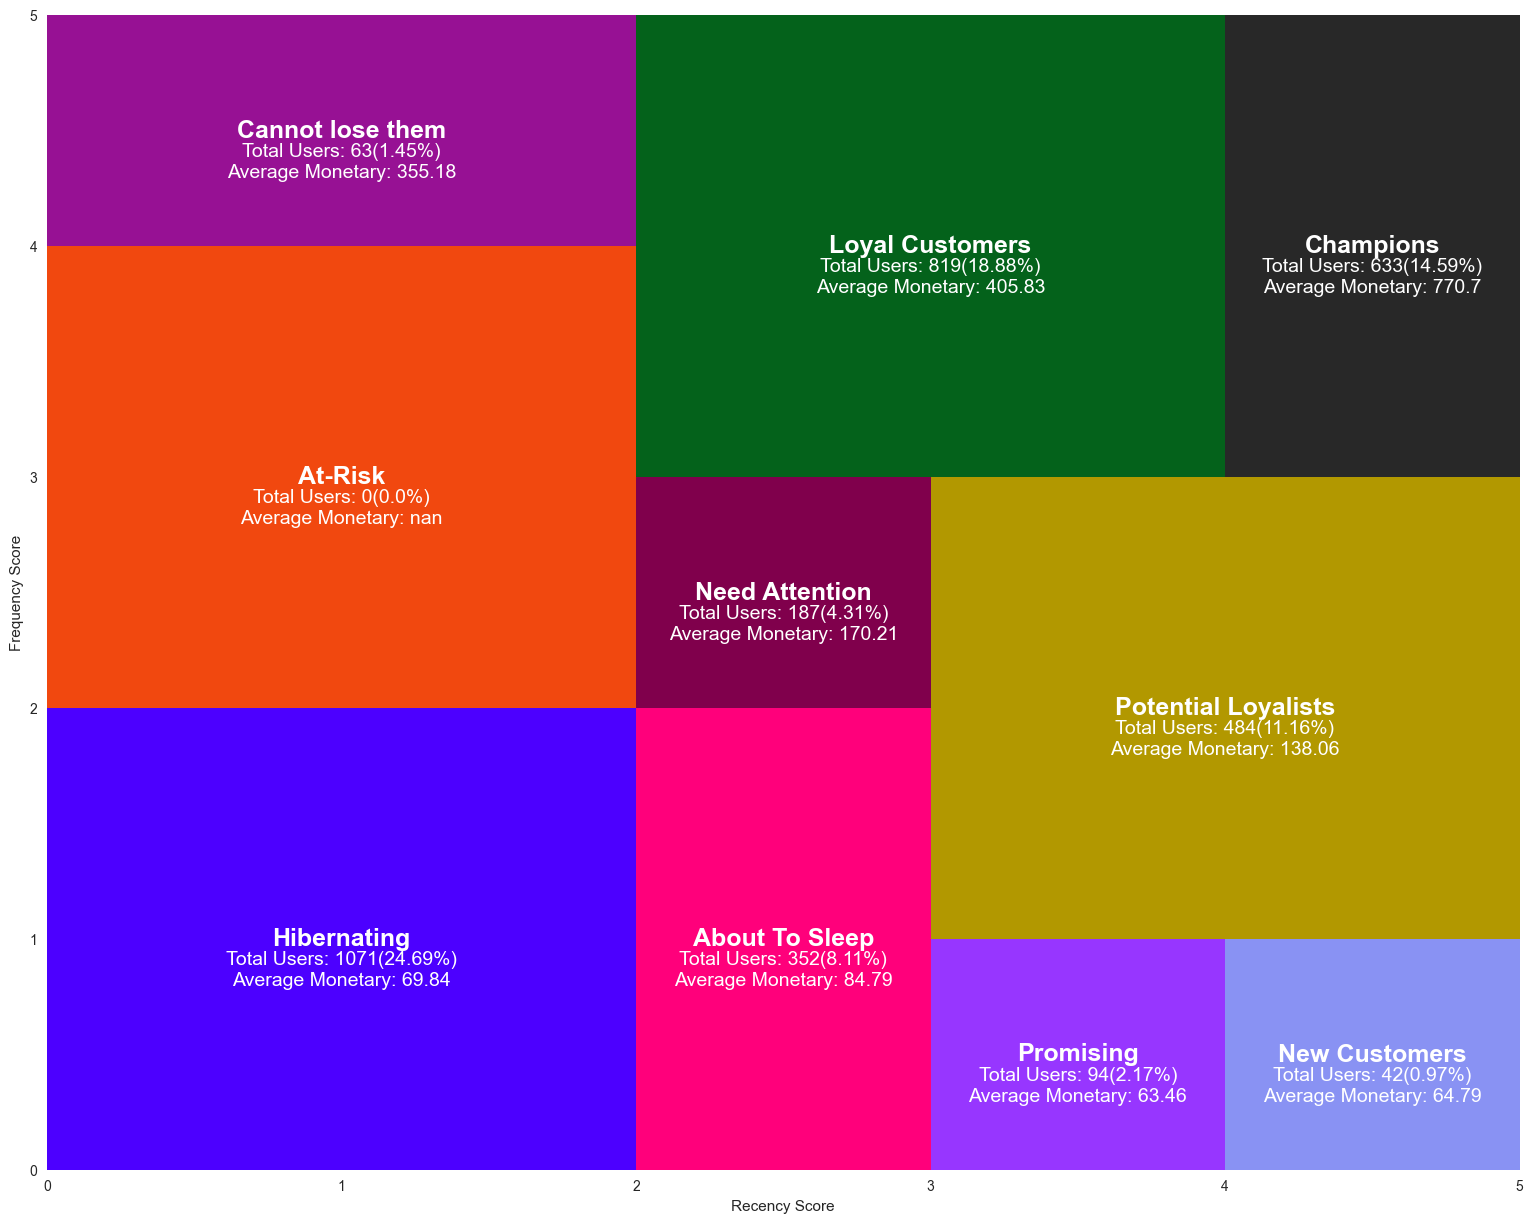

In [54]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = df_rfm[df_rfm.segment == key].shape[0]
    users_percentage = (df_rfm[df_rfm.segment == key].shape[0] / df_rfm.shape[0]) * 100
    avg_monetary = df_rfm[df_rfm.segment == key]["Monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

In [55]:
# Top10 
top10= df_rfm["segment"].value_counts()[:10]
fig = px.bar(y=top10.values,
             x=top10.index,
             text_auto=True,
             title="RFM",
             template="ggplot2")
fig.show()

🛍️ K-Means Clustering 👨🏻‍💻

In [56]:
rfm_table = df_rfm.copy()
rfm_clustering = rfm_table[["Recency", "Frequency", "Monetary", "segment"]]

for col in ["Recency", "Frequency", "Monetary"]:
    scaler = StandardScaler()
    rfm_clustering[col] = np.log(rfm_clustering[col])
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[col].values.reshape(-1,1))

rfm_melted = pd.melt(rfm_clustering, id_vars="segment", value_vars=[
                     "Recency", "Frequency", "Monetary"], var_name= "RFM", value_name= "Value")

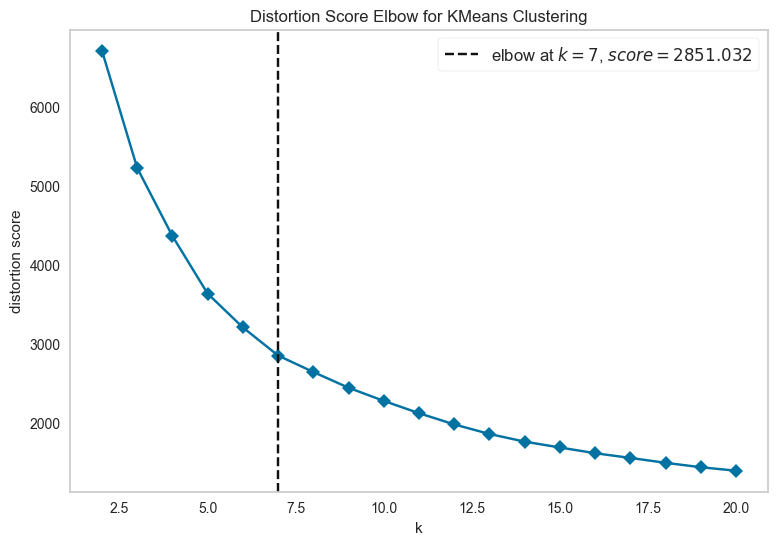

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
features = ["Recency", "Frequency", "Monetary"]
kmeans_ = KMeans(random_state=42)

fig , ax = plt.subplots(figsize = (9,6))
ax.grid(False)

visualizer  = KElbowVisualizer(kmeans_, k=(2,21),timings=False)

visualizer.fit(rfm_clustering[features])
visualizer.show()

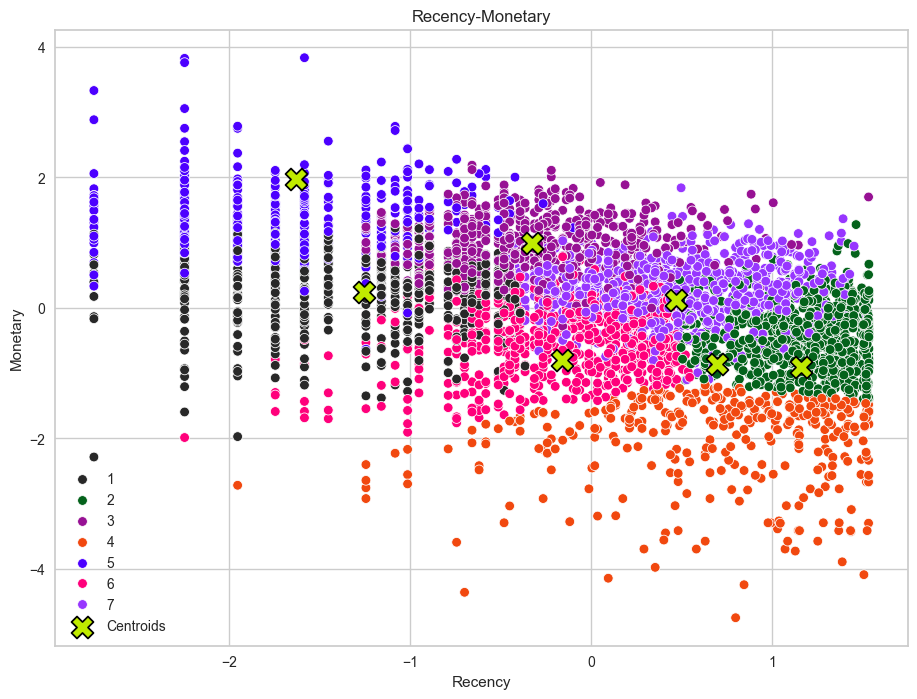

In [58]:
from itertools import combinations
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(rfm_clustering[features])
cluster = (kmeans.labels_)+1

fig= plt.subplots(figsize=(11,8))

for i, features in list(enumerate(combinations(["Recency", "Monetary"],2))):
    sns.scatterplot(x=rfm_clustering[features[0]], y= rfm_clustering[features[1]],
                    hue = cluster, palette = palette[:len(set(cluster))],).set_title(features[0] + "-" +features[1])
    sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y= kmeans.cluster_centers_[:, 1], 
                    s= 250, color= '#C0EB00', label= 'Centroids', marker= 'X', edgecolor= 'black')

plt.show()

🕵️‍♀️ Recommender System 🕵️‍♀️

In [59]:
from mlxtend.frequent_patterns import apriori, association_rules

def create_invoice_product_df(dataframe):
    return dataframe.groupby(['InvoiceNo', "StockCode"])['Quantity'].sum().unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0)

def check_id(dataframe, stock_code):
    product_name = dataframe[dataframe["StockCode"] == stock_code][["Description"]].values[0].tolist()
    print(product_name)

def create_rules(dataframe, use_id=True, country="France", min_support=0.01, min_threshold=0.01):
    dataframe = dataframe[dataframe['Country'] == country]
    dataframe = create_invoice_product_df(dataframe)
    frequent_itemsets = apriori(dataframe, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="support", min_threshold=min_threshold)
    return rules

# Usage
df_rec = df.copy()
rules = create_rules(df_rec, use_id=True, country="France", min_support=0.05, min_threshold=0.05)
result = rules[(rules["support"] > 0.05) & (rules["confidence"] > 0.1) & (rules["lift"] > 5)].sort_values("confidence", ascending=False)
print(result)



              antecedents           consequents  antecedent support  \
220        (21086, 21080)               (21094)            0.102828   
219        (21094, 21080)               (21086)            0.102828   
327  (21094, 21080, POST)               (21086)            0.084833   
329  (21086, 21080, POST)               (21094)            0.084833   
40                (21094)               (21086)            0.128535   
..                    ...                   ...                 ...   
298         (22629, POST)               (22630)            0.097686   
366               (22728)  (22727, 22726, POST)            0.102828   
299               (22630)         (22629, POST)            0.100257   
300               (22629)         (22630, POST)            0.125964   
105               (22382)               (22662)            0.120823   

     consequent support   support  confidence      lift  leverage  conviction  \
220            0.128535  0.100257    0.975000  7.585500  0.087040 

In [60]:
product_id = "21094"
check_id(df_rec, product_id)

sorted_rules = rules.sort_values("lift", ascending=False)

recommendation_list = []

for i, product in enumerate(sorted_rules["antecedents"]):
    for j in list(product):
        if j == product_id:
            recommendation_list.append(
                list(sorted_rules.iloc[i]["consequents"])[0])

recommendation_list[0:3]

['SET/6 RED SPOTTY PAPER PLATES']


['21086', '21086', '21086']

In [61]:
check_id(df_rec , "22729")


def arl_recommender(rules_df, product_id, rec_count=1):
    sorted_rules = rules.sort_values("lift", ascending=False)
    recommendation_list=[]

    for i, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])

    return recommendation_list[0:rec_count]


arl_recommender(rules, "21094", 1)

['ALARM CLOCK BAKELIKE ORANGE']


['21086']

In [62]:
check_id(df_rec, "22728")
rec = arl_recommender(rules, "22728", 3)
code_names = []
code = rec
for col in code:
  code_names.append(check_id(df_rec, col))

['ALARM CLOCK BAKELIKE PINK']
['ALARM CLOCK BAKELIKE RED ']
['ALARM CLOCK BAKELIKE RED ']
['ALARM CLOCK BAKELIKE GREEN']
